# Heart Rate Monitor example

This notebook showcases the use of Temporian to preprocess the raw ECG signal from a patient monitor to detect heart beats and compute the patient's heart rate.

## Imports

In [1]:
import os
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import temporian as tp
import wfdb
from PIL import Image, ImageDraw, ImageFont
from IPython import display

## Load the data

We'll be using the data from a single patient of the [Apnea-ECG Database](https://www.physionet.org/content/apnea-ecg/1.0.0/).

In [2]:
patients = ["a01"]

tmp_directory = "../data/heart_rate_monitor"
if not os.path.isdir(tmp_directory):
    wfdb.dl_database(
        "apnea-ecg",
        dl_dir=tmp_directory,
        records=patients + [f"{p}r" for p in patients],
    )

In [3]:
def wfdb_to_pandas(key: str) -> pd.DataFrame:
    """Convert the PhysioNet into a Pandas DataFrame.""" 

    # Raw signals.
    signals, medadata = wfdb.rdsamp(f"{tmp_directory}/{key}")
    df = pd.DataFrame(signals, columns=medadata["sig_name"])

    # Generate timestamps
    df["timestamp"] = np.arange(medadata["sig_len"]) / medadata["fs"]

    return df

wfdb_to_pandas("a01").head()

,ECG,timestamp
0,-0.060,0.00
1,-0.065,0.01
2,-0.060,0.02
3,-0.075,0.03
4,-0.065,0.04


In [4]:
def load_all_patients(patients: List[str]) -> Tuple[tp.EventSet, tp.EventSet]:

    ecg_dfs = [wfdb_to_pandas(p) for p in patients]
    res_dfs = [wfdb_to_pandas(p + "r") for p in patients]

    merged_ecg_dfs = pd.concat([d.assign(patient=p) for d, p in zip(ecg_dfs, patients)])
    merged_res_dfs = pd.concat([d.assign(patient=p) for d, p in zip(res_dfs, patients)])
    
    return (
        tp.from_pandas(merged_ecg_dfs, indexes=["patient"]),
        tp.from_pandas(merged_res_dfs, indexes=["patient"]),
    )

ecg_evset, resp_evset = load_all_patients(patients)

## Visualize and plot the raw data

In [5]:
ecg_evset

timestamp,ECG
0,-0.06
0.01,-0.065
0.02,-0.06
0.03,-0.075
0.04,-0.065
…,…


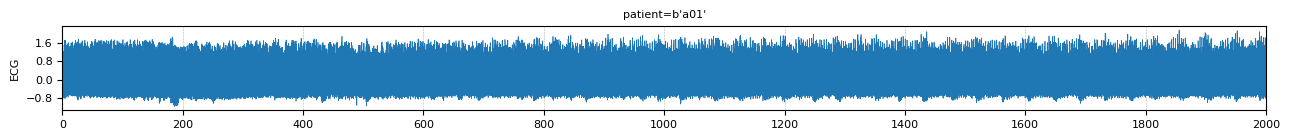

In [19]:
plot_args = {
    "min_time": 0,        # Start time of the plotting
    "max_time": 2000,       # End time of the plotting
    "indexes": "a01",     # Restrict the plotting to patient "a01"
    # "interactive": True,  # Enable interactive plotting
    "width_px": 1300,      # Make sure controls are visible
}
tp.plot([ecg_evset], **plot_args)

## Compute the heart beats and heart rate!

In just 5 lines of Temporian code.

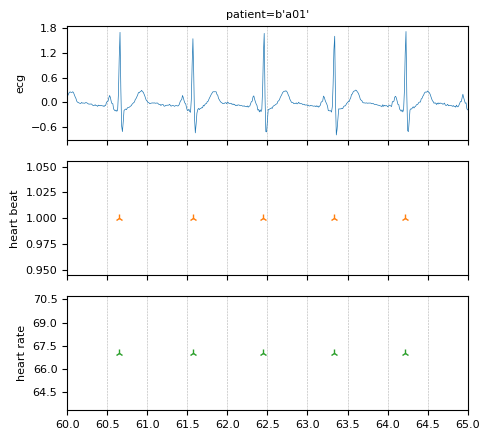

In [7]:
ecg = ecg_evset.rename("ecg")

# Detect heart beats
mmin, mmax = ecg.moving_min(3.0), ecg.moving_max(3.0)
criterion_1 = ecg_evset > mmin + (mmax - mmin) * 0.7
criterion_2 = criterion_1.filter().since_last() > 60.0 / 200
heart_beats = criterion_2.filter().rename("heart beat")

# Compute heart rate
heart_rate = heart_beats.moving_count(tp.duration.seconds(60)).rename("heart rate")

tp.plot([ecg, heart_beats, heart_rate], min_time=60, max_time=65, width_px=500)

## Bonus: creating a gif to show our detections!

In [10]:
raw_ecg = tp.to_pandas(ecg)
raw_heart_beats = tp.to_pandas(heart_beats)
raw_heart_rate = tp.to_pandas(heart_rate)

start = 1400
end = start + 500
raw_ecg = raw_ecg[(raw_ecg["timestamp"]>start) & (raw_ecg["timestamp"]<end)]
raw_heart_beats = raw_heart_beats[(raw_heart_beats["timestamp"]>start-100) & (raw_heart_beats["timestamp"]<end)]
raw_heart_rate = raw_heart_rate[(raw_heart_rate["timestamp"]>start-100) & (raw_heart_rate["timestamp"]<end)]

print(raw_ecg.head())
print(raw_heart_beats.head())
print(raw_heart_rate.head())

       patient    ecg  timestamp
140001     a01  0.120    1400.01
140002     a01  0.100    1400.02
140003     a01  0.075    1400.03
140004     a01  0.045    1400.04
140005     a01  0.015    1400.05
     patient  heart beat  timestamp
1529     a01        True    1300.57
1530     a01        True    1301.48
1531     a01        True    1302.46
1532     a01        True    1303.42
1533     a01        True    1304.37
     patient  heart rate  timestamp
1529     a01          67    1300.57
1530     a01          68    1301.48
1531     a01          68    1302.46
1532     a01          68    1303.42
1533     a01          67    1304.37


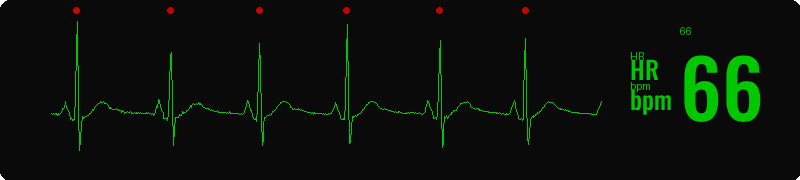

In [11]:
images = []

width = 800
height = 180

# https://fonts.google.com/specimen/Oswald?preview.text=60%0A
font = ImageFont.truetype("../assets/Oswald-Medium.ttf", 80)
font_small = ImageFont.truetype("../assets/Oswald-Medium.ttf", 25)

# References:
# https://media.istockphoto.com/id/824943026/de/vektor/patienten-%C3%A4rztliche-untersuchung-vital-aufsteller.jpg?s=2048x2048&w=is&k=20&c=zxPL66fGCrrXM9VrlyUzD050bqGTL0IsLacUEpk65MA=
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQLbPqnqgBSpi9kduBGHyL-JZkl6zohtYe8RJyMufXgL41-xRD-1EmyU9ktZjtW05mnUkc
# https://www.youtube.com/watch?v=j85yh4eeF7Q
xscale = 90
win = 6.5
yscale = 50
start_time = raw_ecg["timestamp"].values[0]
num_steps = 200
num_rounds = 1 +  20 # Reduce e.g. 2 during dev. Set to 1+20 for final render.
bk=10
last_image = Image.new("RGBA", (width, height), (bk, bk, bk, 0))

#  outline="yellow", 
ImageDraw.Draw(last_image).rounded_rectangle((0, 0, width, height), fill=(bk, bk, bk, 255),width=0, radius=10)

def plot_curve(draw, xs,ys,cx,cy,xscale,yscale):
    mask = xs>=0
    xs = xs[mask]
    ys = ys[mask]

    xs = xs * xscale + cx
    ys = - ys * yscale + cy

    draw.line(list(zip(xs,ys)), fill=(0, 200, 0), width = 0) 

bip_left = 0
last_hb = 0
for round in range(num_rounds):

    for step in range(num_steps):
        progression = step / num_steps
    
        image = last_image.copy()
        draw = ImageDraw.Draw(image)

        l = 20 + win * progression * xscale
        draw.rectangle([l, 0, l+30, height],fill=(bk, bk, bk), width=0)

        ts = raw_ecg["timestamp"].values  - start_time 
        value = raw_ecg["ecg"].values
        mask = ts < win * progression
        ts = ts[mask]
        value = value[mask]

        plot_curve(draw, ts, value, 20, 110, xscale, yscale)

        hb = raw_heart_beats["timestamp"][raw_heart_beats["timestamp"] < (start_time + win * progression)].values[-1]
        l = 20 + (hb - start_time) * xscale
        if hb >= start_time:
            cx = l
            cy = 10
            r = 3
            draw.ellipse((cx-r,cy-r,cx+r,cy+r), fill=(200, 0, 0))

            if last_hb != hb:
                last_hb = hb
                bip_left = 7

        last_image = image.copy()

        hr = raw_heart_rate["heart rate"][raw_heart_rate["timestamp"] < (start_time + win * progression)].values[-1]
        
        # Text
        draw.text((width - 120, 25), f"{hr}", font=font, fill=(0, 200, 0))
        draw.text((width - 170, 50), "HR", font=font_small, fill=(0, 200, 0))
        draw.text((width - 170, 80), "bpm", font=font_small, fill=(0, 200, 0))
        draw.text((width - 120, 25), f"{hr}", fill=(0, 200, 0))
        draw.text((width - 170, 50), "HR", fill=(0, 200, 0))
        draw.text((width - 170, 80), "bpm", fill=(0, 200, 0))

        # Bip
        if bip_left>0:
            cx = width - 20
            cy = 90
            r = 10
            draw.ellipse((cx-r,cy-r,cx+r,cy+r), fill=(255, 0, 0))
            bip_left -= 1

        if round > 0:
            images.append(image)

    start_time += win

images[0].save("../data/heart_rate_monitor/anim.gif", save_all=True, append_images=images[1:], optimize=True, duration=1000/30, loop=0)
display.display(display.Image(open("../data/heart_rate_monitor/anim.gif","rb").read()))
